## Business Goal
The aim is  to segement the Customers based on RFM so that the company can target its customers efficiently.

#### The steps are broadly divided into:

1. [Step 1: Reading and Understanding the Data](#1)
1. [Step 2: Data Cleansing](#2)
1. [Step 3: Exploratory Data Analysis](#3)
1. [Step 4: Calculating RFM](#4)
1. [Step 5: Model Building](#5)
1. [Step 6: 5)	Explain the different customer segments after the clusters are created](#6)

<a id="1"></a> <br>
## Step 1 : Reading and Understanding Data

In [ ]:
#Import libraries
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings # Uyarılar
warnings.filterwarnings("ignore")
from IPython.display import display

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [ ]:
df=pd.read_csv('Sample - Superstore Sales (Excel).csv',encoding="ISO-8859-1")

In [ ]:
df.head(2)

,Row ID,Order ID,Order Date,Month Year,Order Priority,Order Quantity,Sales,Customer Name,Province,Region,Product Category,Product Sub-Category,Product Name
0,1,3,10/13/2010,10-01-2010,Low,6,261.54,Muhammed MacIntyre,Nunavut,Nunavut,Office Supplies,Storage & Organization,"Eldon Base for stackable storage shelf, platinum"
1,49,293,10-01-2012,10-01-2012,High,49,10123.02,Barry French,Nunavut,Nunavut,Office Supplies,Appliances,"1.7 Cubic Foot Compact ""Cube"" Office Refrigera..."


In [ ]:
df.info()
## WE should change the datatype of order Date  to Datetime format
## Should change the Order ID to object type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8399 entries, 0 to 8398
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Row ID                8399 non-null   int64  
 1   Order ID              8399 non-null   int64  
 2   Order Date            8399 non-null   object 
 3   Month Year            8399 non-null   object 
 4   Order Priority        8399 non-null   object 
 5   Order Quantity        8399 non-null   int64  
 6   Sales                 8399 non-null   float64
 7   Customer Name         8399 non-null   object 
 8   Province              8399 non-null   object 
 9   Region                8399 non-null   object 
 10  Product Category      8399 non-null   object 
 11  Product Sub-Category  8399 non-null   object 
 12  Product Name          8399 non-null   object 
dtypes: float64(1), int64(3), object(9)
memory usage: 853.1+ KB


In [ ]:
df.shape
## There are 8399 rows an 13 columns

(8399, 13)

In [ ]:
# Unique Invoice Count
print("Unique Order Count: ", df["Order ID"].nunique())

# Unique Customer Count
print("Unique Customer Count: ", df["Customer Name"].nunique())

Unique Order Count:  5496
Unique Customer Count:  795


<font color="darkblue">795 customers made 5496 orders</font>

<a id="2"></a> <br>
## Step 2 : Data Cleansing

In [ ]:
## Dropping unwanted columns
df.drop(columns=['Row ID'],inplace=True)

In [ ]:
# Changing the datatype of order Id as per Business understanding
df['Order ID'] = df['Order ID'].astype(str)

In [ ]:
# Changing the datatype of Order Date to Datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'])

In [ ]:
## sorting the data according to the order date to get more clarity
df=df.sort_values(by='Order Date')
df.head(4)

,Order ID,Order Date,Month Year,Order Priority,Order Quantity,Sales,Customer Name,Province,Region,Product Category,Product Sub-Category,Product Name
3142,13729,2009-01-01,01-01-2009,Not Specified,9,872.48,Matt Collister,Quebec,Quebec,Office Supplies,Storage & Organization,Safco Industrial Wire Shelving
4376,28774,2009-01-01,01-01-2009,High,32,180.36,Jessica Myrick,Ontario,Ontario,Office Supplies,Storage & Organization,"Perma STOR-ALL Hanging File Box, 13 1/8""W x 1..."
7055,37537,2009-01-02,01-01-2009,Low,4,1239.06,Alan Schoenberger,British Columbia,West,Furniture,Chairs & Chairmats,Hon 4070 Series Pagoda Armless Upholstered St...
7056,37537,2009-01-02,01-01-2009,Low,43,4083.19,Alan Schoenberger,British Columbia,West,Furniture,Chairs & Chairmats,Hon Valutask Swivel Chairs


In [ ]:
# Calculating the Missing Values % contribution in DF
df_null = round(100*(df.isnull().sum())/len(df), 2)
df_null
## There are no null values present

Order ID                0.0
Order Date              0.0
Month Year              0.0
Order Priority          0.0
Order Quantity          0.0
Sales                   0.0
Customer Name           0.0
Province                0.0
Region                  0.0
Product Category        0.0
Product Sub-Category    0.0
Product Name            0.0
dtype: float64

<a id="1"></a> <br>
## Step 3 : Exploratory Data Analysis

### 1) Top 3 Total and  Average of Sales per customer

In [ ]:
# Top 3 customers by Total Sales
top_total_sales_customers = df.groupby('Customer Name')['Sales'].sum().rename('Total Sales').nlargest(3)
# Top 3 customers by Average Sales
top_average_sales_customers = df.groupby('Customer Name')['Sales'].mean().rename('Average Sales').nlargest(3)

display(top_total_sales_customers.reset_index())
display(top_average_sales_customers.reset_index())

,Customer Name,Total Sales
0,Emily Phan,117124.4380
1,Deborah Brumfield,97433.1355
2,Roy Skaria,92542.1530


,Customer Name,Average Sales
0,Craig Carreira,41343.2100
1,Emily Phan,11712.4438
2,Rick Reed,10696.1400


#### Craig Carreira is the top in term of avergae sales
#### In terms of total sales Emily Phan is the highest
####  It may be the reason that Emily Phan have ordered more times than Craig Carreira
#### This we can verify using the count of the orders made my each customers

### 2) Top Total Orders per customer

In [ ]:
total_orders_customers = df.groupby('Customer Name')['Order ID'].nunique() \
    .rename('Total Order').sort_values(ascending=False)
total_orders_customers = total_orders_customers.reset_index()
total_orders_customers.head(5)

,Customer Name,Total Order
0,Darren Budd,26
1,Brad Thomas,24
2,Ed Braxton,22
3,Jack O'Briant,21
4,Carlos Soltero,20


#### Darren Budd made the highest number of orders.This shows that frequency for this customer is very high

In [ ]:
emily_order_count = total_orders_customers.loc[total_orders_customers['Customer Name'] == 'Emily Phan', 'Total Order'].values[0]
print(f"Order count for Emily Phan: {emily_order_count}")
emily_order_count = total_orders_customers.loc[total_orders_customers['Customer Name'] == 'Craig Carreira', 'Total Order'].values[0]
print(f"Order count for ECraig Carreira: {emily_order_count}")


Order count for Emily Phan: 8
Order count for ECraig Carreira: 1


####  Emily Phan ordered 10 times compared to ECraig Carreira who ordered only once  so that have the highest total sales value

### 3) Total Transaction Size and number of orders  by product category

In [ ]:
category_order_count = df.groupby('Product Category')['Order ID'].nunique() \
    .reset_index().rename(columns={'Order ID': 'Order Count'})

merged_df = df.groupby('Product Category')['Sales'].sum().reset_index() \
    .rename(columns={'Sales': 'Total Sales'}).sort_values(by='Total Sales', ascending=False)
merged_df = merged_df.merge(category_order_count, on='Product Category')
merged_df

,Product Category,Total Sales,Order Count
0,Technology,5984248.182,1858
1,Furniture,5178590.542,1561
2,Office Supplies,3752762.100,3632


#### Customers ordered more in Technology catergory and this catergory made the highest sales

### 4) Total Sales by Province and Region

In [ ]:
sales_by_region = df.groupby(['Province', 'Region'])['Sales'].sum().reset_index()

In [ ]:
sales_by_region.sort_values(by='Sales',ascending=False).head(5)

,Province,Region,Sales
8,Ontario,Ontario,3.063212e+06
1,British Columbia,West,1.892758e+06
0,Alberta,West,1.704791e+06
10,Quebec,Quebec,1.510195e+06
11,Saskachewan,Prarie,1.464456e+06


#### Ontario region in  Ontario province made the highest sales

### 5) Number of Orders Per Sub Catergory


In [ ]:
product_counts = df.groupby(['Product Sub-Category'])['Order ID'].nunique().reset_index()
product_counts = product_counts.sort_values(by='Order ID', ascending=False)
product_counts.rename(columns={'Order ID': 'Total Orders'}, inplace=True)
product_counts.head(5)

,Product Sub-Category,Total Orders
10,Paper,1150
1,Binders and Binder Accessories,868
16,Telephones and Communication,840
8,Office Furnishings,757
4,Computer Peripherals,731


<a id="1"></a> <br>
## Step 4 : Calculating RFM

In [ ]:
print(df['Order Date'].max())
## This is the last date hwen the order was placed
## Since its historical data we can take a today after this as the recent day
recent_day=dt.datetime(2012,12, 31)

2012-12-30 00:00:00


In [ ]:
## Here as Customer id is not provided we group using customer name
rfm = df.groupby('Customer Name').agg({'Order Date': lambda date: (recent_day - date.max()).days,
                                     'Order ID': lambda num: num.nunique(),
                                     'Sales': lambda TotalPrice: TotalPrice.sum()})
rfm.columns=["Recency","Frequency","Monetary"]
rfm = rfm[rfm["Monetary"] > 0]
rfm.reset_index()

,Customer Name,Recency,Frequency,Monetary
0,Aaron Bergman,583,5,11630.5900
1,Aaron Hawkins,368,9,27690.7255
2,Aaron Smayling,347,8,8835.3235
3,Adam Bellavance,90,8,11577.5800
4,Adam Hart,20,18,26114.2645
...,...,...,...,...
790,Vivian Mathis,55,11,29420.8900
791,William Brown,11,15,38872.5900
792,Xylona Price,25,7,18037.0855
793,Yana Sorensen,133,6,1987.1600


### _Outlier Analysis and removal of the RFM Dataframe_

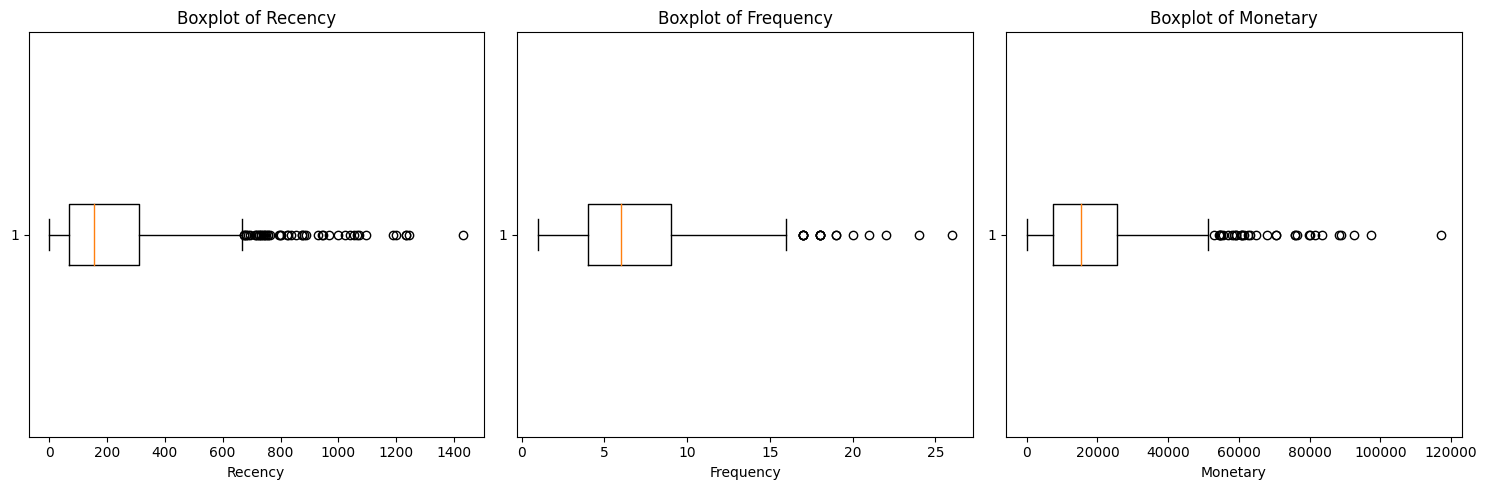

In [ ]:
import matplotlib.pyplot as plt
columns = ["Recency", "Frequency", "Monetary"]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, column in enumerate(columns):
    ax = axes[i]
    ax.boxplot(rfm[column], vert=False)
    ax.set_title(f'Boxplot of {column}')
    ax.set_xlabel(column)
plt.tight_layout()
plt.show()
## Recency have more outliers

In [ ]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df
rfm = remove_outliers_iqr(rfm, 'Recency')
rfm = remove_outliers_iqr(rfm, 'Frequency')
rfm = remove_outliers_iqr(rfm, 'Monetary')
rfm=rfm.reset_index()
rfm.head(5)

,Customer Name,Recency,Frequency,Monetary
0,Aaron Bergman,583,5,11630.5900
1,Aaron Hawkins,368,9,27690.7255
2,Aaron Smayling,347,8,8835.3235
3,Adam Bellavance,90,8,11577.5800
4,Adam Shillingsburg,508,10,20059.6755


<a id="1"></a> <br>
## Step 5: Model Building

### Before Model building we should do the the processes like Scaling

### _Scaling the numerical variables_

In [ ]:
rfm_df=rfm[['Recency','Frequency','Monetary']]
scaler = StandardScaler()
rfm_model_scaled = scaler.fit_transform(rfm_df)
rfm_model_scaled = pd.DataFrame(rfm_model_scaled)
rfm_model_scaled.columns=['Recency','Frequency','Monetary']
rfm_model_scaled.head(5)

,Recency,Frequency,Monetary
0,2.358247,-0.545730,-0.441331
1,1.038700,0.792744,0.935521
2,0.909814,0.458126,-0.680972
3,-0.667504,0.458126,-0.445876
4,1.897940,1.127362,0.281303


### _Model building using K Means Clustering_

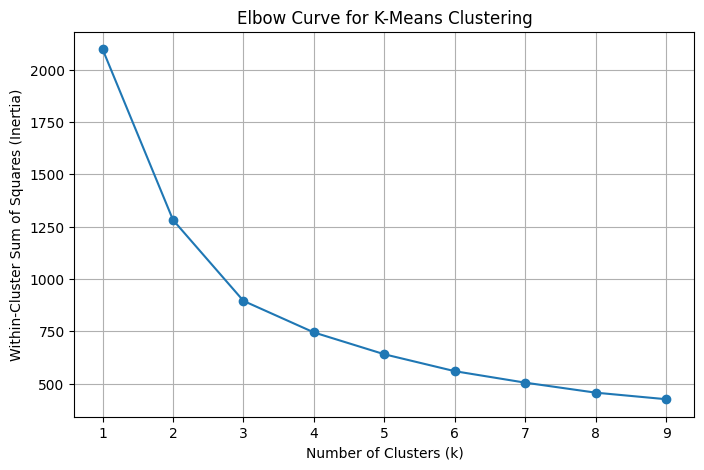

In [ ]:
## Elbow curve to find the right number of clusters
k_values = range(1, 10)
inertia_values = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_model_scaled)
    inertia_values.append(kmeans.inertia_)
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (Inertia)')
plt.title('Elbow Curve for K-Means Clustering')
plt.grid(True)
plt.show()

In [ ]:
# Silhouette Analysis
k_values = range(2, 10)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(rfm_model_scaled)
    silhouette_avg = silhouette_score((rfm_model_scaled),cluster_labels)
    silhouette_scores.append(silhouette_avg)
results_df = pd.DataFrame({'Number of Clusters (k)': k_values, 'Silhouette Score': silhouette_scores})
results_df

,Number of Clusters (k),Silhouette Score
0,2,0.342004
1,3,0.339073
2,4,0.317778
3,5,0.280998
4,6,0.287818
5,7,0.278732
6,8,0.271411
7,9,0.268707


In [ ]:
#Create a K-Means model with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(rfm_model_scaled)

In [ ]:
## Adding the cluster segmentation  to th rfm we created
rfm['Customer Segmentation']=cluster_labels

In [ ]:
## To vizualise the number of records in each cluster
rfm['Customer Segmentation'].value_counts()

2    299
0    247
1    153
Name: Customer Segmentation, dtype: int64

<a id="1"></a> <br>
## Step 6: Explainining the different customer segments after the clusters are created

### _Cluster statistics_

In [ ]:
cluster_statistics = rfm.groupby('Customer Segmentation').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median']
})
cluster_statistics

Recency        Frequency             Monetary  \
                             mean median      mean median          mean   
Customer Segmentation                                                     
0                      136.186235  108.0  9.408907    9.0  28869.382121   
1                      446.450980  433.0  4.549020    5.0   9821.310709   
2                      123.705686  116.0  5.401338    5.0  10350.283059   

                                   
                           median  
Customer Segmentation              
0                      27898.8725  
1                       8608.3500  
2                       9564.4800

### _Scatter plot_ ###

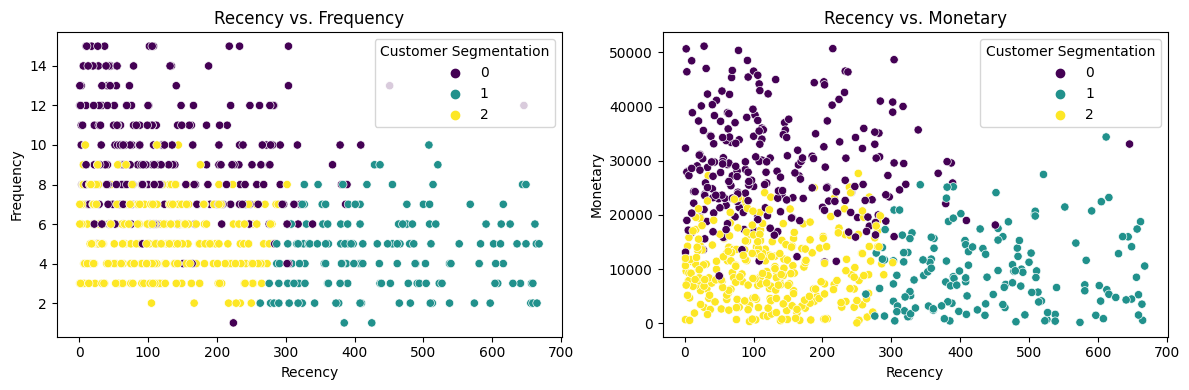

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Customer Segmentation', palette='viridis', ax=axes[0])
axes[0].set_title('Recency vs. Frequency')
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Customer Segmentation', palette='viridis', ax=axes[1])
axes[1].set_title('Recency vs. Monetary')

plt.tight_layout()
plt.show()

### **Important Point:**

- **Cluster 0** - Less Recency, Largest Frequency, and Largest Monetary
- **Cluster 2** - Lowest Recency, Moderate Frequency, and Low Monetary
- **Cluster 1** - Highest Recency, Lowest Frequency, and Lowest Monetary

### _Box plot between customers and  RMF_

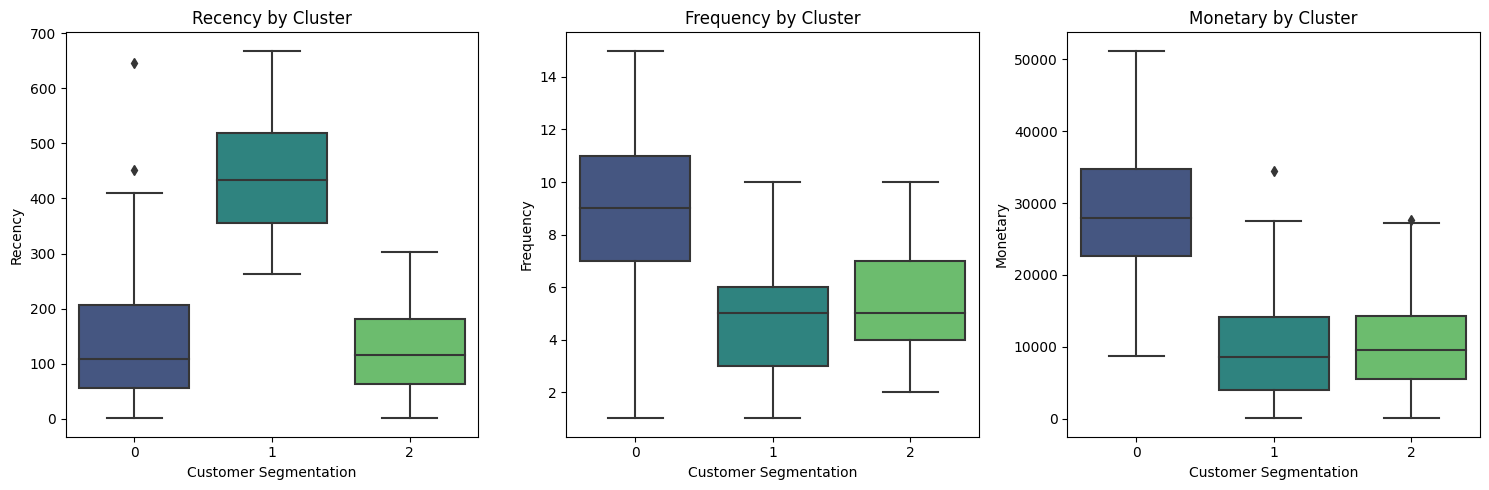

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
variables = ['Recency', 'Frequency', 'Monetary']
fig, axes = plt.subplots(1, len(variables), figsize=(15, 5))

for i, variable in enumerate(variables):
    sns.boxplot(x='Customer Segmentation', y=variable, data=rfm, palette='viridis', ax=axes[i])
    axes[i].set_title(f'{variable} by Cluster')

plt.tight_layout()
plt.show()


### **The same results we can see from the Box-Plots also** ##

**Cluster Designation Based on Properties:**

- **Cluster 0:** **High-Value** Customers
  - *Reasoning:* Cluster 0 consists of customers with less recency, the largest frequency, and the largest monetary value, indicating they are high-value customers for the business.

- **Cluster 2:** **Moderate-Value** Customers
  - *Reasoning:* Cluster 2 includes customers with the lowest recency, moderate frequency, and low monetary value, suggesting they are of moderate value to the business.

- **Cluster 1:** **Low-Value** Customers
  - *Reasoning:* Cluster 1 comprises customers with the highest recency, the lowest frequency, and the lowest monetary value, indicating they are low-value customers for the business.



 **The decision on the number of clusters and the exploration of different clustering models should be based on the specific use case and the requirements of the business domain**